In [1]:
# Data Structures
import numpy  as np
import pandas as pd
import geopandas as gpd
import json

# Corpus Processing
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

In [2]:
df = pd.read_csv('BBC News Train.csv',engine='python')
df.columns = map(str.lower, df.columns)

In [3]:
df["text"] = df["text"].astype(str)

In [4]:
corpus = df['text'].tolist()
corpus[1][0:447]

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy.  munich-based research institute ifo said that its confidence index fell to 95.5 in february from 97.5 in january  its first decline in three months. the study found that the outlook in both the manufacturing and retail sectors had worsened. observers had been hoping that a more confident business secto'

## Data Preprocessing

In [5]:
# removes a list of words (ie. stopwords) from a tokenized list.
def removeWords(listOfTokens, listOfWords):
    return [token for token in listOfTokens if token not in listOfWords]

# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]

# removes any words composed of less than 2 or more than 21 letters
def twoLetters(listOfTokens):
    twoLetterWord = []
    for token in listOfTokens:
        if len(token) <= 2 or len(token) >= 21:
            twoLetterWord.append(token)
    return twoLetterWord

In [6]:
def processCorpus(corpus, language):   
    stopwords = nltk.corpus.stopwords.words(language)
    param_stemmer = SnowballStemmer(language)
    other_words = [line.rstrip('\n') for line in open('stopwords_scrapmaker.txt')] # Load .txt file line by line
    
    for document in corpus:
        index = corpus.index(document)
        corpus[index] = corpus[index].replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
        corpus[index] = corpus[index].replace(',', '')          # Removes commas
        corpus[index] = corpus[index].rstrip('\n')              # Removes line breaks
        corpus[index] = corpus[index].casefold()                # Makes all letters lowercase
        
        corpus[index] = re.sub('\W_',' ', corpus[index])        # removes specials characters and leaves only words
        corpus[index] = re.sub("\S*\d\S*"," ", corpus[index])   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
        corpus[index] = re.sub("\S*@\S*\s?"," ", corpus[index]) # removes emails and mentions (words with @)
        corpus[index] = re.sub(r'http\S+', '', corpus[index])   # removes URLs with http
        corpus[index] = re.sub(r'www\S+', '', corpus[index])    # removes URLs with www
        #remove punctuations
        corpus[index] = re.sub(r'[^\w]|_',' ',corpus[index])
        #Remove additional white spaces
        corpus[index] = re.sub('[\s]+', ' ', corpus[index])

        listOfTokens = word_tokenize(corpus[index])
        twoLetterWord = twoLetters(listOfTokens)

        listOfTokens = removeWords(listOfTokens, stopwords)
        listOfTokens = removeWords(listOfTokens, twoLetterWord)
        listOfTokens = removeWords(listOfTokens, other_words)
        
        listOfTokens = removeWords(listOfTokens, other_words)

        corpus[index]   = " ".join(listOfTokens)
        corpus[index] = unidecode(corpus[index])

    return corpus

In [7]:
language = 'english'
corpus = processCorpus(corpus, language)
corpus[18]

'melzer shocks agassi san jose seed andre agassi suffered comprehensive defeat jurgen melzer quarter finals sap open agassi bamboozled austrian drop shots san jose losing defending champion top seed andy roddick rallied beat sweden thomas enqvist unseeded cyril saulnier beat fourth seed vincent spadea tommy haas overcame eighth seed max mirnyi melzer beaten agassi meetings good game plan executed perfectly tough play andre play game makes run dog court agassi matched power opponent handed backhand melzer players tour chances lot guys capable american played times opportunities loosen agassi added convert big points'

In [8]:
from pandas import DataFrame

df['text'] = DataFrame (corpus)
print (df)

      articleid                                               text  \
0          1833  worldcom boss launches defence lawyers defendi...   
1           154  german business confidence slides german busin...   
2          1101  bbc poll economic gloom citizens majority nati...   
3          1976  lifestyle governs mobile choice faster funkier...   
4           917  enron bosses payout eighteen enron directors a...   
...         ...                                                ...   
1485        857  double eviction big brother model caprice holb...   
1486        325  double act revamp chart show duo joel taking b...   
1487       1590  weak dollar hits reuters revenues media group ...   
1488       1587  apple ipod family expands market apple expande...   
1489        538  santy worm makes unwelcome visit thousands web...   

           category  
0          business  
1          business  
2          business  
3              tech  
4          business  
...             ...  
1485 

In [9]:
df = df.drop_duplicates()
df = df[df['text'].notna()]

In [10]:
import nltk
nltk.download('words')
words = set(nltk.corpus.words.words())

def clean_sent(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
     if w.lower() in words or not w.isalpha())

[nltk_data] Downloading package words to C:\Users\Frans
[nltk_data]     Sitohang\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [11]:
df['text'] = df['text'].apply(clean_sent)

In [12]:
df['text']

0       boss defence chief battery fraud company witne...
1       german business confidence german business con...
2       poll economic gloom majority world service pol...
3       mobile choice faster hardware phone sell resea...
4       eighteen agreed settlement deal shareholder la...
                              ...                        
1485    double eviction big brother model caprice city...
1486    double act revamp chart show duo taking radio ...
1487    weak dollar media group slipped due weakness d...
1488    apple family market apple expanded family rele...
1489    worm unwelcome visit bulletin virus spread net...
Name: text, Length: 1490, dtype: object

In [13]:
from nltk.stem import PorterStemmer, WordNetLemmatizer
porter_stemmer = PorterStemmer()

def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

df['text'] = df['text'].apply(stem_sentences)

In [14]:
df.to_csv('BBC News Clean.csv')

In [15]:
sample=pd.read_csv("BBC News Clean.csv",engine='python')

## Classification

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-deep')
from sklearn.metrics import confusion_matrix
import nltk

In [17]:
sample.head(5)

,Unnamed: 0,articleid,text,category
0,0,1833,boss defenc chief batteri fraud compani wit co...,business
1,1,154,german busi confid german busi confid fell kno...,business
2,2,1101,poll econom gloom major world servic poll worl...,business
3,3,1976,mobil choic faster hardwar phone sell research...,tech
4,4,917,eighteen agre settlement deal sharehold lawsui...,business


In [18]:
del sample['Unnamed: 0']
sample.head(5)

,articleid,text,category
0,1833,boss defenc chief batteri fraud compani wit co...,business
1,154,german busi confid german busi confid fell kno...,business
2,1101,poll econom gloom major world servic poll worl...,business
3,1976,mobil choic faster hardwar phone sell research...,tech
4,917,eighteen agre settlement deal sharehold lawsui...,business


In [19]:
sample.category.value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: category, dtype: int64

### Train and Test Dataset

In [20]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(sample, test_size=0.2)

In [21]:
train_arr=train['text'].tolist()
test_arr=test['text'].tolist()
train_lbl = train['category'].tolist()
test_lbl = test['category'].tolist()

## TF-IDF

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [23]:
vectorizer = CountVectorizer()
vectorizer.fit(train_arr)
train_mat = vectorizer.transform(train_arr)
print (train_mat.shape)
test_mat = vectorizer.transform(test_arr)
print (test_mat.shape)

(1192, 7585)
(298, 7585)


In [24]:
tfidf = TfidfTransformer()
tfidf.fit(train_mat)
train_tfmat = tfidf.transform(train_mat)
print (train_tfmat.shape)
test_tfmat = tfidf.transform(test_mat)
print (test_tfmat.shape)

(1192, 7585)
(298, 7585)


In [25]:
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from pprint import pprint
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix,accuracy_score

In [26]:
import numpy as np

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Naive Baiyes Classifier

### Bernoulli NB

In [28]:
bnb= BernoulliNB()
#fitting
bnb.fit(train_tfmat, train_lbl)
#ypred
ypredBnb = bnb.predict(test_tfmat)
print ('Bernoulli accuracy score')
print (accuracy_score(test_lbl, ypredBnb))

Bernoulli accuracy score
0.9429530201342282


[[69  0  0  0  0]
 [ 0 48  0  1  0]
 [ 4  0 51  0  0]
 [ 1  0  0 72  0]
 [ 7  4  0  0 41]]


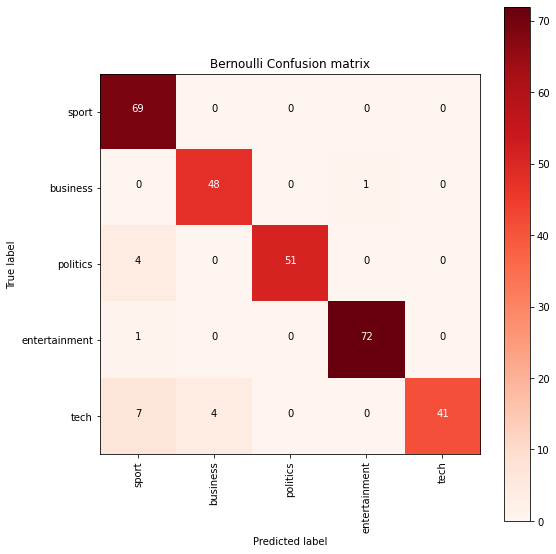

In [29]:
class_names=['sport','business','politics','entertainment','tech']
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_lbl, ypredBnb), classes=class_names,
                      title='Bernoulli Confusion matrix')

plt.show()

### MultinomialNB

In [30]:
mnb=MultinomialNB()
#fitting
mnb.fit(train_tfmat, train_lbl)
ypredMnb = mnb.predict(test_tfmat)
print ('Multinomial accuracy score')
print (accuracy_score(test_lbl, ypredMnb))

Multinomial accuracy score
0.9697986577181208


[[69  0  0  0  0]
 [ 0 48  0  1  0]
 [ 2  0 52  0  1]
 [ 0  0  0 73  0]
 [ 5  0  0  0 47]]


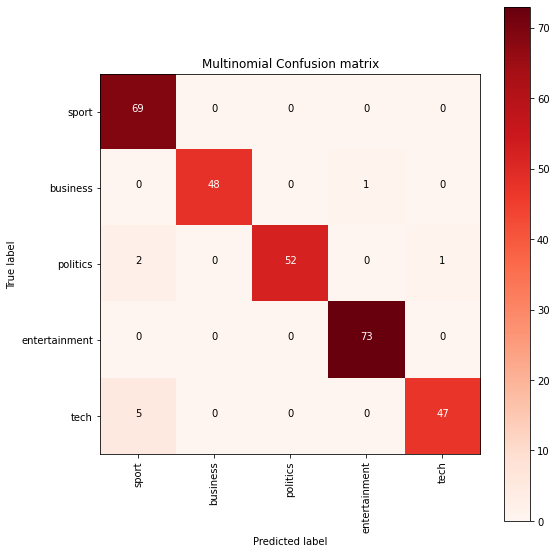

In [31]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_lbl, ypredMnb), classes=class_names,
                      title='Multinomial Confusion matrix')

plt.show()

### Karena MultinomialNB lebih tinggi akurasinya, maka kita akan memakai MultinomialNB

In [32]:
print ('Bernoulli accuracy score')
print (accuracy_score(test_lbl, ypredBnb))
print ('Multinomial accuracy score')
print (accuracy_score(test_lbl, ypredMnb))

Bernoulli accuracy score
0.9429530201342282
Multinomial accuracy score
0.9697986577181208


## Test Input

In [33]:
news_title = """'Opportunity and threat' of pandemic tech advances"""

print(mnb.predict(vectorizer.transform([news_title])))

['tech']
